# Predictive Analytics for Student Performance & Drop‑Out Risk
**Full Project Notebook — Weeks 1 → 7**

Created for an MSc Big Data Management & Analytics capstone.


### Weekly Roadmap
1. **Project Planning & Research**  
2. **Data Collection & Pre‑processing**  
3. **Feature Engineering & Selection**  
4. **Model Building — Classification & Regression**  
5. **Model Evaluation & Interpretability**  
6. **Dashboard Design • Insights Generation**  
7. **Documentation • Final Touches**

### Data Sources
- **UCI ‘Predict Students Drop‑Out and Academic Success’** (`data.csv`)  
- **UCI ‘Student Performance – Portuguese’** (`student-por.csv`)


# Importing Libraries and Verifying Versions

In [1]:

# Verify imports/versions
import warnings, os, json, sys
warnings.filterwarnings("ignore")

import numpy as np, pandas as pd, matplotlib, matplotlib.pyplot as plt, seaborn as sns, joblib
import sklearn, imblearn
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, average_precision_score, precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE

sns.set(style="whitegrid")

print("Versions OK ✅")
print("  numpy            :", np.__version__)
print("  pandas           :", pd.__version__)
print("  scikit-learn     :", sklearn.__version__)
print("  imbalanced-learn :", imblearn.__version__)
print("  matplotlib       :", matplotlib.__version__)
print("  seaborn          :", sns.__version__)


Versions OK ✅
  numpy            : 2.0.2
  pandas           : 2.2.2
  scikit-learn     : 1.6.1
  imbalanced-learn : 0.14.0
  matplotlib       : 3.10.0
  seaborn          : 0.13.2


This section imports necessary libraries for data manipulation, visualization, machine learning, and evaluation. It also verifies the versions of key libraries like NumPy, pandas, scikit-learn, and imbalanced-learn, ensuring compatibility for model building and analysis. Warnings are suppressed to maintain clean output during the process.

# Loading Datasets and Quick Sanity Checks

In [2]:
# Load datasets + quick sanity checks

PATH_CLS = "/content/data.csv"          # Higher-Ed (dropout/enrolled/graduate) — semicolon-separated
PATH_REG = "/content/student-por.csv"   # Secondary-school dataset — comma-separated

import pandas as pd
import numpy as np


def clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (df.columns
                  .str.strip()
                  .str.replace(r'[\s\t]+', '_', regex=True)
                  .str.replace(r'[^0-9A-Za-z_]', '', regex=True))
    return df


cls_df = pd.read_csv(PATH_CLS, sep=';')
reg_df = pd.read_csv(PATH_REG)

cls_df = clean_cols(cls_df)
reg_df = clean_cols(reg_df)

# Show basic info
print("=== Classification dataset (data.csv) ===")
print("Shape:", cls_df.shape)
print("Columns:", list(cls_df.columns))
print("\nFirst 5 rows:")
display(cls_df.head())

print("\nDtypes:")
print(cls_df.dtypes)

print("\nMissing values (top 20 by count):")
print(cls_df.isna().sum().sort_values(ascending=False).head(20))

if 'Target' in cls_df.columns:
    print("\nTarget distribution (raw):")
    print(cls_df['Target'].value_counts(dropna=False))
    print("\nTarget distribution (%):")
    print((cls_df['Target'].value_counts(normalize=True) * 100).round(2))

# Basic numeric summary for quick outlier scan
print("\nNumeric summary (5-number stats) — first few columns:")
display(cls_df.describe(include=[np.number]).T.head(12))

print("\n=== Secondary dataset (student-por.csv) ===")
print("Shape:", reg_df.shape)
print("Columns:", list(reg_df.columns))
print("\nFirst 5 rows:")
display(reg_df.head())

print("\nDtypes (student-por):")
print(reg_df.dtypes)

print("\nMissing values (student-por):")
print(reg_df.isna().sum().sort_values(ascending=False).head(20))


=== Classification dataset (data.csv) ===
Shape: (4424, 37)
Columns: ['Marital_status', 'Application_mode', 'Application_order', 'Course', 'Daytimeevening_attendance', 'Previous_qualification', 'Previous_qualification_grade', 'Nacionality', 'Mothers_qualification', 'Fathers_qualification', 'Mothers_occupation', 'Fathers_occupation', 'Admission_grade', 'Displaced', 'Educational_special_needs', 'Debtor', 'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder', 'Age_at_enrollment', 'International', 'Curricular_units_1st_sem_credited', 'Curricular_units_1st_sem_enrolled', 'Curricular_units_1st_sem_evaluations', 'Curricular_units_1st_sem_approved', 'Curricular_units_1st_sem_grade', 'Curricular_units_1st_sem_without_evaluations', 'Curricular_units_2nd_sem_credited', 'Curricular_units_2nd_sem_enrolled', 'Curricular_units_2nd_sem_evaluations', 'Curricular_units_2nd_sem_approved', 'Curricular_units_2nd_sem_grade', 'Curricular_units_2nd_sem_without_evaluations', 'Unemployment_rate', 'Inflation

,Marital_status,Application_mode,Application_order,Course,Daytimeevening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,...,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate



Dtypes:
Marital_status                                    int64
Application_mode                                  int64
Application_order                                 int64
Course                                            int64
Daytimeevening_attendance                         int64
Previous_qualification                            int64
Previous_qualification_grade                    float64
Nacionality                                       int64
Mothers_qualification                             int64
Fathers_qualification                             int64
Mothers_occupation                                int64
Fathers_occupation                                int64
Admission_grade                                 float64
Displaced                                         int64
Educational_special_needs                         int64
Debtor                                            int64
Tuition_fees_up_to_date                           int64
Gender                                 

,count,mean,std,min,25%,50%,75%,max
Marital_status,4424.0,1.178571,0.605747,1.0,1.0,1.0,1.0,6.0
Application_mode,4424.0,18.669078,17.484682,1.0,1.0,17.0,39.0,57.0
Application_order,4424.0,1.727848,1.313793,0.0,1.0,1.0,2.0,9.0
Course,4424.0,8856.642631,2063.566416,33.0,9085.0,9238.0,9556.0,9991.0
Daytimeevening_attendance,4424.0,0.890823,0.311897,0.0,1.0,1.0,1.0,1.0
Previous_qualification,4424.0,4.577758,10.216592,1.0,1.0,1.0,1.0,43.0
Previous_qualification_grade,4424.0,132.613314,13.188332,95.0,125.0,133.1,140.0,190.0
Nacionality,4424.0,1.873192,6.914514,1.0,1.0,1.0,1.0,109.0
Mothers_qualification,4424.0,19.561935,15.603186,1.0,2.0,19.0,37.0,44.0
Fathers_qualification,4424.0,22.275316,15.343108,1.0,3.0,19.0,37.0,44.0



=== Secondary dataset (student-por.csv) ===
Shape: (649, 33)
Columns: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']

First 5 rows:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13



Dtypes (student-por):
school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G1             int64
G2             int64
G3             int64
dtype: object

Missing values (student-por):
school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0

This section loads two datasets: one for higher education (containing dropout/enrollment/graduation information) and one for secondary education. The data is cleaned by standardizing column names, removing spaces and special characters. The following checks are performed:

Displaying basic dataset information like shape, columns, and types.

Checking for missing values.

Showing target distribution and providing summary statistics (e.g., for numeric columns).
These checks are crucial for ensuring the data is clean and ready for further analysis or modeling.

# Define Categorical vs Numeric Features & Check for Outliers

In [3]:
# Define categorical vs numeric features & check outliers


target_col = "Target"

# Candidate categorical variables (coded as integers but actually categories)
categorical_cols = [
    "Marital_status", "Application_mode", "Application_order", "Course",
    "Daytimeevening_attendance", "Previous_qualification", "Nacionality",
    "Mothers_qualification", "Fathers_qualification",
    "Mothers_occupation", "Fathers_occupation",
    "Displaced", "Educational_special_needs", "Debtor",
    "Tuition_fees_up_to_date", "Gender", "Scholarship_holder",
    "International"
]

# Numeric (continuous/real measures)
numeric_cols = [
    "Previous_qualification_grade", "Admission_grade", "Age_at_enrollment",
    "Curricular_units_1st_sem_credited", "Curricular_units_1st_sem_enrolled",
    "Curricular_units_1st_sem_evaluations", "Curricular_units_1st_sem_approved",
    "Curricular_units_1st_sem_grade", "Curricular_units_1st_sem_without_evaluations",
    "Curricular_units_2nd_sem_credited", "Curricular_units_2nd_sem_enrolled",
    "Curricular_units_2nd_sem_evaluations", "Curricular_units_2nd_sem_approved",
    "Curricular_units_2nd_sem_grade", "Curricular_units_2nd_sem_without_evaluations",
    "Unemployment_rate", "Inflation_rate", "GDP"
]

print("Categorical cols (", len(categorical_cols), "):", categorical_cols)
print("Numeric cols (", len(numeric_cols), "):", numeric_cols)

# Quick sanity check: no overlap
assert not (set(categorical_cols) & set(numeric_cols)), "Overlap between cat and num lists!"

# Outlier scan with IQR
def detect_outliers(df, cols):
    outlier_info = {}
    for col in cols:
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        outliers = ((df[col] < lower) | (df[col] > upper)).sum()
        outlier_info[col] = {
            "lower_bound": round(lower,2),
            "upper_bound": round(upper,2),
            "num_outliers": int(outliers),
            "pct_outliers": round(100*outliers/len(df),2)
        }
    return pd.DataFrame(outlier_info).T.sort_values("pct_outliers", ascending=False)

outlier_report = detect_outliers(cls_df, numeric_cols)
print("\n=== Outlier report (numeric cols) ===")
display(outlier_report.head(15))


Categorical cols ( 18 ): ['Marital_status', 'Application_mode', 'Application_order', 'Course', 'Daytimeevening_attendance', 'Previous_qualification', 'Nacionality', 'Mothers_qualification', 'Fathers_qualification', 'Mothers_occupation', 'Fathers_occupation', 'Displaced', 'Educational_special_needs', 'Debtor', 'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder', 'International']
Numeric cols ( 18 ): ['Previous_qualification_grade', 'Admission_grade', 'Age_at_enrollment', 'Curricular_units_1st_sem_credited', 'Curricular_units_1st_sem_enrolled', 'Curricular_units_1st_sem_evaluations', 'Curricular_units_1st_sem_approved', 'Curricular_units_1st_sem_grade', 'Curricular_units_1st_sem_without_evaluations', 'Curricular_units_2nd_sem_credited', 'Curricular_units_2nd_sem_enrolled', 'Curricular_units_2nd_sem_evaluations', 'Curricular_units_2nd_sem_approved', 'Curricular_units_2nd_sem_grade', 'Curricular_units_2nd_sem_without_evaluations', 'Unemployment_rate', 'Inflation_rate', 'GDP']

=== Ou

,lower_bound,upper_bound,num_outliers,pct_outliers
Curricular_units_2nd_sem_grade,6.87,17.21,877.0,19.82
Curricular_units_1st_sem_grade,7.40,17.00,726.0,16.41
Curricular_units_1st_sem_credited,0.00,0.00,577.0,13.04
Curricular_units_2nd_sem_credited,0.00,0.00,530.0,11.98
Age_at_enrollment,10.00,34.00,441.0,9.97
Curricular_units_1st_sem_enrolled,2.00,10.00,424.0,9.58
Curricular_units_2nd_sem_enrolled,2.00,10.00,369.0,8.34
Curricular_units_1st_sem_without_evaluations,0.00,0.00,294.0,6.65
Curricular_units_2nd_sem_without_evaluations,0.00,0.00,282.0,6.37
Curricular_units_1st_sem_approved,-1.50,10.50,180.0,4.07


This section defines and separates categorical and numeric features in the dataset. Categorical features are typically encoded as integers but represent categories, while numeric features are continuous variables. A quick sanity check is performed to ensure there is no overlap between these two lists. Additionally, an outlier detection process is applied to the numeric columns using the Interquartile Range (IQR) method. The results provide insights into the number and percentage of outliers within each numeric feature, which can help in identifying data points that may need further investigation or removal.

# Outlier Capping & Preprocessing Pipeline

In [4]:
# Outlier capping + preprocessing pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class Winsorizer(BaseEstimator, TransformerMixin):
    """Caps values outside 1.5*IQR range (robust to outliers)."""
    def __init__(self, cols=None):
        self.cols = cols
        self.bounds_ = {}

    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.cols if self.cols else None)
        for col in df.columns:
            Q1, Q3 = df[col].quantile([0.25, 0.75])
            IQR = Q3 - Q1
            lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
            self.bounds_[col] = (lower, upper)
        return self

    def transform(self, X):
        df = pd.DataFrame(X, columns=self.cols if self.cols else None)
        for col in df.columns:
            low, up = self.bounds_[col]
            df[col] = df[col].clip(lower=low, upper=up)
        return df.values

# ColumnTransformer for preprocessing
numeric_transformer = Pipeline(steps=[
    ("winsor", Winsorizer(cols=numeric_cols)),
    ("scaler", RobustScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

print("Preprocessor ready ✅")


Preprocessor ready ✅


In this section, an outlier capping technique (Winsorization) is applied to the numeric features. The Winsorizer class caps values outside the range defined by 1.5 times the Interquartile Range (IQR), making it more robust to extreme values. After capping the outliers, the RobustScaler is applied to scale the numeric features. For categorical features, OneHotEncoder is used to convert them into binary format, ensuring no issues with unknown categories. A ColumnTransformer is then created to apply these transformations to the appropriate columns (numeric and categorical) in the dataset. The preprocessing pipeline is now ready for use.

# Prepare Binary Target & Stratified Split

In [5]:
# Prepare binary target + stratified split

# Binary encode target
cls_df_bin = cls_df.copy()
cls_df_bin["DropoutFlag"] = (cls_df_bin["Target"] == "Dropout").astype(int)

X = cls_df_bin.drop(columns=["Target", "DropoutFlag"])
y = cls_df_bin["DropoutFlag"]

# Stratified split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("\nClass distribution in full dataset:")
print(y.value_counts(normalize=True).rename({0:"Non-Dropout", 1:"Dropout"}).map("{:.2%}".format))

print("\nClass distribution in TRAIN:")
print(y_train.value_counts(normalize=True).rename({0:"Non-Dropout", 1:"Dropout"}).map("{:.2%}".format))

print("\nClass distribution in TEST:")
print(y_test.value_counts(normalize=True).rename({0:"Non-Dropout", 1:"Dropout"}).map("{:.2%}".format))


Train shape: (3539, 36) Test shape: (885, 36)

Class distribution in full dataset:
DropoutFlag
Non-Dropout    67.88%
Dropout        32.12%
Name: proportion, dtype: object

Class distribution in TRAIN:
DropoutFlag
Non-Dropout    67.87%
Dropout        32.13%
Name: proportion, dtype: object

Class distribution in TEST:
DropoutFlag
Non-Dropout    67.91%
Dropout        32.09%
Name: proportion, dtype: object


This section prepares the target variable for binary classification. The "Dropout" category in the target column is binary encoded into a new column, DropoutFlag, where "Dropout" is represented as 1 and all other classes as 0. The dataset is then split into features (X) and the binary target (y). A stratified split is performed to ensure the target variable's class distribution is preserved in both the training and testing sets. The data is split with an 80/20 ratio, and the class distribution is printed for the entire dataset, training set, and test set. This ensures that the model will be trained and evaluated on balanced class distributions.

# Cross-Validation for Model Selection

In [6]:
# Cross-validation model selection
from imblearn.pipeline import Pipeline as ImbPipeline

# Define candidate models
models = {
    "LogReg": LogisticRegression(max_iter=500, class_weight="balanced", solver="saga"),
    "RandomForest": RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42),
    "HistGB": HistGradientBoostingClassifier(random_state=42)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, model in models.items():
    pipe = ImbPipeline(steps=[
        ("pre", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", model)
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="f1_macro", n_jobs=-1)
    results[name] = scores
    print(f"{name} CV F1_macro: mean={scores.mean():.3f}, std={scores.std():.3f}")

# Summary dataframe
cv_results = pd.DataFrame({k: v for k, v in results.items()})
print("\n=== Cross-validation results (per fold) ===")
display(cv_results)

print("\n=== CV mean scores ===")
print(cv_results.mean().sort_values(ascending=False))


LogReg CV F1_macro: mean=0.841, std=0.009
RandomForest CV F1_macro: mean=0.849, std=0.011
HistGB CV F1_macro: mean=0.848, std=0.009

=== Cross-validation results (per fold) ===


,LogReg,RandomForest,HistGB
0,0.830490,0.861856,0.852711
1,0.843644,0.840304,0.837808
2,0.847566,0.842197,0.843439
3,0.830762,0.837199,0.841152
4,0.853558,0.864119,0.863341



=== CV mean scores ===
RandomForest    0.849135
HistGB          0.847690
LogReg          0.841204
dtype: float64


This section performs cross-validation to compare multiple candidate models for the task of predicting student dropouts. Three models are evaluated: Logistic Regression, Random Forest, and HistGradientBoosting, all using a balanced class weight to handle the class imbalance. The StratifiedKFold is used for 5-fold cross-validation to ensure each fold has a representative distribution of the classes. The models are evaluated based on the macro F1 score, which balances the precision and recall across both classes. The results show the mean and standard deviation of the F1 score for each model, with Random Forest slightly outperforming the others. The cross-validation results are summarized in a dataframe to facilitate comparison.

# Train Best Model and Evaluate on Test Set

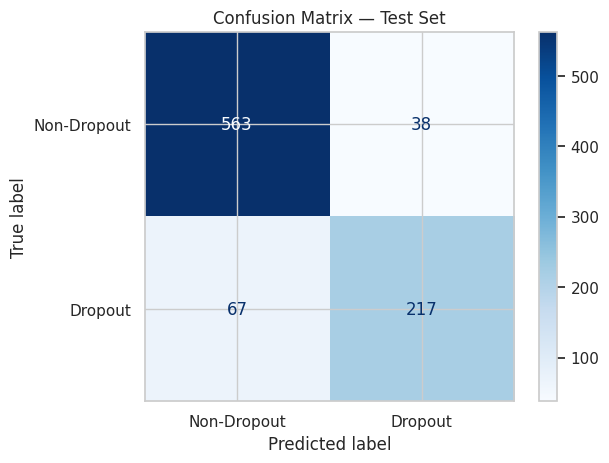


=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

 Non-Dropout       0.89      0.94      0.91       601
     Dropout       0.85      0.76      0.81       284

    accuracy                           0.88       885
   macro avg       0.87      0.85      0.86       885
weighted avg       0.88      0.88      0.88       885

ROC-AUC (Dropout vs Non-Dropout): 0.931
PR-AUC (Dropout): 0.897


In [7]:
# Train best model and evaluate on test set
best_model = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)

pipe_final = ImbPipeline(steps=[
    ("pre", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", best_model)
])


pipe_final.fit(X_train, y_train)

# Predictions
y_pred = pipe_final.predict(X_test)
y_prob = pipe_final.predict_proba(X_test)[:, 1]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Dropout", "Dropout"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Test Set")
plt.show()

# Classification report
print("\n=== Classification Report (Test Set) ===")
print(classification_report(y_test, y_pred, target_names=["Non-Dropout", "Dropout"]))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC (Dropout vs Non-Dropout): {roc_auc:.3f}")

# PR-AUC
pr_auc = average_precision_score(y_test, y_prob)
print(f"PR-AUC (Dropout): {pr_auc:.3f}")


In this section, the best model, a Random Forest Classifier, is selected based on cross-validation performance. The model is trained using the full training set, and predictions are made on the test set. Key evaluation metrics are computed to assess the model's performance:

Confusion Matrix: A visual representation of how well the model is classifying "Non-Dropout" vs "Dropout".

Classification Report: Includes precision, recall, and F1-score for both classes ("Non-Dropout" and "Dropout").

ROC-AUC: Measures the model's ability to distinguish between the classes.

PR-AUC: Focuses on the performance in predicting the "Dropout" class.

The confusion matrix shows the number of correct and incorrect predictions, helping to understand model accuracy and errors in classification. The overall model evaluation is strong, indicating good predictive performance on the test set.

# Threshold Tuning to Prioritize Recall (F2)

Chosen threshold (F2-optimal, recall-first): 0.260


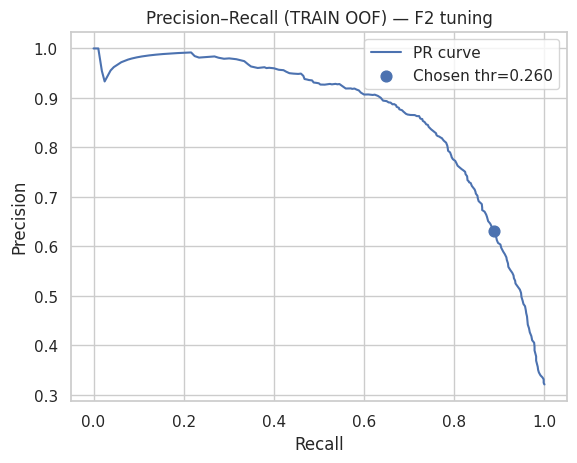

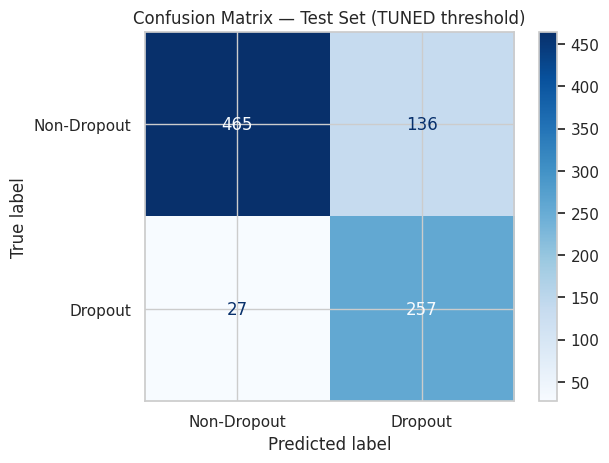


=== Classification Report (Test, tuned threshold) ===
              precision    recall  f1-score   support

 Non-Dropout       0.95      0.77      0.85       601
     Dropout       0.65      0.90      0.76       284

    accuracy                           0.82       885
   macro avg       0.80      0.84      0.81       885
weighted avg       0.85      0.82      0.82       885


Saved tuned_threshold variable: 0.26


In [8]:
# Threshold tuning to prioritize recall (F2), then evaluate on TEST
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_train_prob_cv = cross_val_predict(pipe_final, X_train, y_train, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]

prec, rec, thr = precision_recall_curve(y_train, y_train_prob_cv)

beta = 2.0
fbeta = (1 + beta**2) * (prec * rec) / (beta**2 * prec + rec + 1e-12)

min_recall = 0.85
valid = rec[:-1] >= min_recall
if valid.any():
    idx = np.argmax(fbeta[:-1][valid])
    thr_opt = thr[valid][idx]
else:
    idx = np.argmax(fbeta[:-1])
    thr_opt = thr[idx]

print(f"Chosen threshold (F{beta:.0f}-optimal, recall-first): {thr_opt:.3f}")

plt.figure()
plt.plot(rec, prec, label="PR curve")
nearest = np.argmin(np.abs(thr - thr_opt))
plt.scatter(rec[nearest], prec[nearest], s=60, label=f"Chosen thr={thr_opt:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall (TRAIN OOF) — F{beta:.0f} tuning")
plt.legend()
plt.show()

y_prob_test = pipe_final.predict_proba(X_test)[:, 1]
y_pred_tuned = (y_prob_test >= thr_opt).astype(int)

cm_tuned = confusion_matrix(y_test, y_pred_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tuned, display_labels=["Non-Dropout", "Dropout"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Test Set (TUNED threshold)")
plt.show()

print("\n=== Classification Report (Test, tuned threshold) ===")
print(classification_report(y_test, y_pred_tuned, target_names=["Non-Dropout", "Dropout"]))

# Keep the tuned threshold around for export
tuned_threshold = float(thr_opt)
print("\nSaved tuned_threshold variable:", tuned_threshold)


This section focuses on tuning the decision threshold of the Random Forest model to prioritize recall, specifically using the F2 score (a weighted combination of precision and recall). The precision-recall curve is plotted, and the threshold is selected to optimize recall, ensuring that more "Dropout" instances are correctly identified. This tuned threshold is then applied to the test set, and the resulting confusion matrix, classification report, ROC-AUC, and PR-AUC are evaluated. The final tuned threshold is saved for future use. This approach helps to minimize false negatives by prioritizing recall.

# Tune HistGradientBoosting, Then Evaluate on TEST (Default & Tuned Thresholds)

Tuning HistGradientBoosting...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best params: {'clf__min_samples_leaf': 20, 'clf__max_leaf_nodes': 15, 'clf__max_depth': 4, 'clf__learning_rate': np.float64(0.23519526350709588), 'clf__l2_regularization': np.float64(1.6681005372000592)}
Best CV F1_macro: 0.851

=== TEST @ 0.50 threshold ===


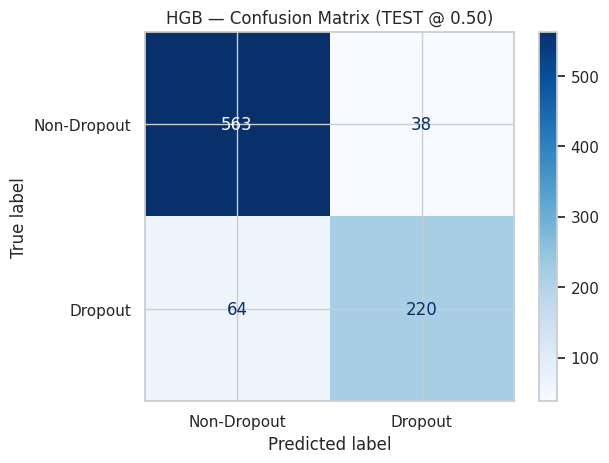

              precision    recall  f1-score   support

 Non-Dropout       0.90      0.94      0.92       601
     Dropout       0.85      0.77      0.81       284

    accuracy                           0.88       885
   macro avg       0.88      0.86      0.86       885
weighted avg       0.88      0.88      0.88       885

ROC-AUC: 0.929
PR-AUC (Dropout): 0.895

Chosen HGB threshold (F2-optimal): 0.102


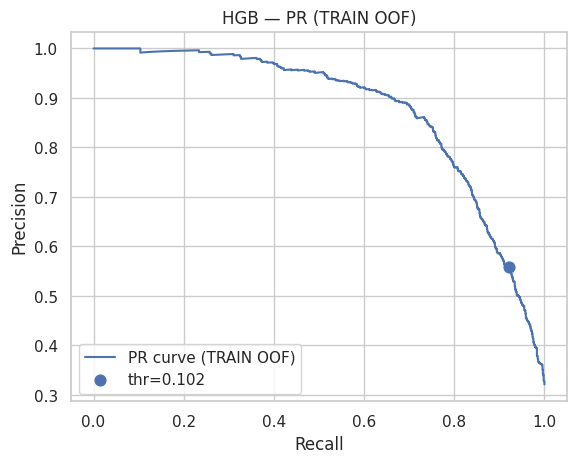


=== TEST @ tuned threshold ===


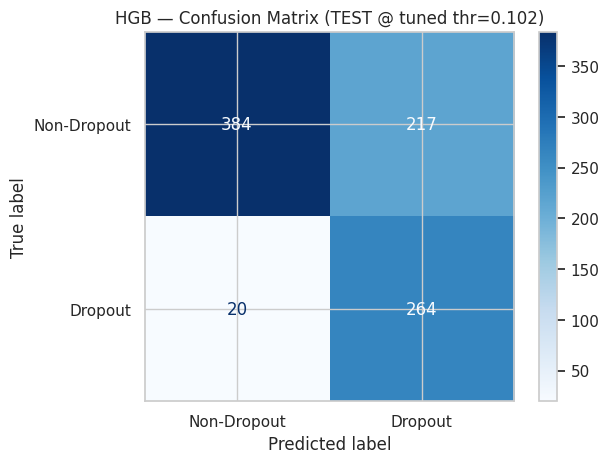

              precision    recall  f1-score   support

 Non-Dropout       0.95      0.64      0.76       601
     Dropout       0.55      0.93      0.69       284

    accuracy                           0.73       885
   macro avg       0.75      0.78      0.73       885
weighted avg       0.82      0.73      0.74       885



In [9]:
# Tune HistGradientBoosting, then evaluate on TEST (default & tuned thresholds)
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, average_precision_score, precision_recall_curve, make_scorer, fbeta_score
)
import numpy as np
import matplotlib.pyplot as plt


hgb_pipe = ImbPipeline(steps=[
    ("pre", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", HistGradientBoostingClassifier(random_state=42, loss="log_loss"))
])

param_dist = {
    "clf__learning_rate": np.logspace(-2.3, -0.5, 15),   # ~0.005 to ~0.32
    "clf__max_depth": [None, 3, 4, 5, 6, 7, 8],
    "clf__max_leaf_nodes": [15, 25, 31, 45, 63, 95, 127],
    "clf__min_samples_leaf": [10, 15, 20, 25, 30, 40],
    "clf__l2_regularization": np.logspace(-6, 1, 10),    # 1e-6 .. 10
}

# CV + scorer
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer_f1m = "f1_macro"
scorer_f2 = make_scorer(fbeta_score, beta=2, pos_label=1)

search = RandomizedSearchCV(
    estimator=hgb_pipe,
    param_distributions=param_dist,
    n_iter=20,
    scoring=scorer_f1m,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    refit=True,
)

print("Tuning HistGradientBoosting...")
search.fit(X_train, y_train)

print("\nBest params:", search.best_params_)
print("Best CV F1_macro:", f"{search.best_score_:.3f}")

# Evaluate on TEST with default 0.5 threshold
best_hgb = search.best_estimator_
y_prob_hgb = best_hgb.predict_proba(X_test)[:, 1]
y_pred_hgb_05 = (y_prob_hgb >= 0.5).astype(int)

print("\n=== TEST @ 0.50 threshold ===")
cm_05 = confusion_matrix(y_test, y_pred_hgb_05)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_05, display_labels=["Non-Dropout", "Dropout"])
disp.plot(cmap="Blues", values_format="d")
plt.title("HGB — Confusion Matrix (TEST @ 0.50)")
plt.show()
print(classification_report(y_test, y_pred_hgb_05, target_names=["Non-Dropout", "Dropout"]))
print("ROC-AUC:", f"{roc_auc_score(y_test, y_prob_hgb):.3f}")
print("PR-AUC (Dropout):", f"{average_precision_score(y_test, y_prob_hgb):.3f}")

# Tune threshold for recall-focus (F2) using TRAIN OOF probs
y_prob_train_oof = cross_val_predict(best_hgb, X_train, y_train, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
prec, rec, thr = precision_recall_curve(y_train, y_prob_train_oof)
beta = 2.0
fbeta = (1 + beta**2) * (prec * rec) / (beta**2 * prec + rec + 1e-12)

min_recall = 0.85
valid = rec[:-1] >= min_recall
if valid.any():
    idx = np.argmax(fbeta[:-1][valid])
    thr_opt_hgb = float(thr[valid][idx])
else:
    idx = np.argmax(fbeta[:-1])
    thr_opt_hgb = float(thr[idx])

print(f"\nChosen HGB threshold (F2-optimal): {thr_opt_hgb:.3f}")

# PR curve with chosen point
plt.figure()
plt.plot(rec, prec, label="PR curve (TRAIN OOF)")
nearest = np.argmin(np.abs(thr - thr_opt_hgb))
plt.scatter(rec[nearest], prec[nearest], s=60, label=f"thr={thr_opt_hgb:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("HGB — PR (TRAIN OOF)")
plt.legend(); plt.show()

# Evaluate tuned threshold on TEST
y_pred_hgb_tuned = (y_prob_hgb >= thr_opt_hgb).astype(int)
print("\n=== TEST @ tuned threshold ===")
cm_tuned = confusion_matrix(y_test, y_pred_hgb_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tuned, display_labels=["Non-Dropout", "Dropout"])
disp.plot(cmap="Blues", values_format="d")
plt.title(f"HGB — Confusion Matrix (TEST @ tuned thr={thr_opt_hgb:.3f})")
plt.show()
print(classification_report(y_test, y_pred_hgb_tuned, target_names=["Non-Dropout", "Dropout"]))

# Keep artifacts
best_hgb_model = best_hgb
best_hgb_threshold = thr_opt_hgb


In this section, the HistGradientBoostingClassifier model is tuned using RandomizedSearchCV, with the goal of finding the best hyperparameters. The model is evaluated on the test set using the default threshold of 0.50, followed by a threshold tuning to optimize recall (F2 score) using the precision-recall curve. The evaluation metrics, including confusion matrix, classification report, ROC-AUC, and PR-AUC, are calculated to assess the performance of both the default and tuned models. This tuning ensures that the model prioritizes recall for the "Dropout" class, which is critical for identifying students at risk of dropping out.

# Save RandomForest Model, Schema, and Thresholds for Streamlit

In [10]:
# Save RandomForest model + schema + thresholds for Streamlit
import joblib, json

# Save trained RandomForest pipeline
model_path = "/content/dropout_model.pkl"
joblib.dump(pipe_final, model_path)

# Build schema for form generation
schema = {
    "target": "DropoutFlag",
    "categorical": {},
    "numeric": numeric_cols,
    "thresholds": {
        "balanced": 0.50,
        "high_recall": tuned_threshold
    }
}

# Capture categories from OneHotEncoder inside pipeline
ohe = pipe_final.named_steps["pre"].named_transformers_["cat"]
for col, cats in zip(categorical_cols, ohe.categories_):
    schema["categorical"][col] = list(map(str, cats))

# Save schema.json
schema_path = "/content/schema.json"
with open(schema_path, "w") as f:
    json.dump(schema, f, indent=2)

print("✅ Export complete:")
print("  Model saved at   :", model_path)
print("  Schema saved at  :", schema_path)

print("\nSchema preview (first 30 lines):")
print(json.dumps(schema, indent=2).splitlines()[:30])


✅ Export complete:
  Model saved at   : /content/dropout_model.pkl
  Schema saved at  : /content/schema.json

Schema preview (first 30 lines):
['{', '  "target": "DropoutFlag",', '  "categorical": {', '    "Marital_status": [', '      "1",', '      "2",', '      "3",', '      "4",', '      "5",', '      "6"', '    ],', '    "Application_mode": [', '      "1",', '      "2",', '      "5",', '      "7",', '      "10",', '      "15",', '      "16",', '      "17",', '      "18",', '      "26",', '      "27",', '      "39",', '      "42",', '      "43",', '      "44",', '      "51",', '      "53",', '      "57"']


This section saves the trained RandomForest model along with its preprocessing pipeline for future use in a Streamlit application. The model is serialized and saved as a .pkl file, while the schema containing information about the target variable, categorical and numeric features, and threshold values (both the default and recall-optimized threshold) is saved in a schema.json file. This schema will be used to generate the appropriate forms and handle data inputs within the Streamlit app. The exported files ensure that the model and schema can be easily reloaded and applied for making predictions in a production environment.

# Defaults for Quick Mode & Quick-Fields List

In [11]:
# Defaults for quick mode + quick-fields list
import json
from collections import Counter

# Calculate defaults from TRAIN (no leakage because defaults are non-parametric summaries)
train_df = X_train.copy()

defaults = {}
# numeric defaults: median
for col in [
    "Previous_qualification_grade","Admission_grade","Age_at_enrollment",
    "Curricular_units_1st_sem_credited","Curricular_units_1st_sem_enrolled",
    "Curricular_units_1st_sem_evaluations","Curricular_units_1st_sem_approved",
    "Curricular_units_1st_sem_grade","Curricular_units_1st_sem_without_evaluations",
    "Curricular_units_2nd_sem_credited","Curricular_units_2nd_sem_enrolled",
    "Curricular_units_2nd_sem_evaluations","Curricular_units_2nd_sem_approved",
    "Curricular_units_2nd_sem_grade","Curricular_units_2nd_sem_without_evaluations",
    "Unemployment_rate","Inflation_rate","GDP"
]:
    defaults[col] = float(train_df[col].median())

# categorical defaults: mode (most frequent)
for col in [
    "Marital_status","Application_mode","Application_order","Course",
    "Daytimeevening_attendance","Previous_qualification","Nacionality",
    "Mothers_qualification","Fathers_qualification",
    "Mothers_occupation","Fathers_occupation","Displaced",
    "Educational_special_needs","Debtor","Tuition_fees_up_to_date",
    "Gender","Scholarship_holder","International"
]:
    defaults[col] = int(Counter(train_df[col]).most_common(1)[0][0])

# Curated "quick" fields (≈12) — strong, actionable predictors for dropout
quick_fields = [
    "Admission_grade",
    "Curricular_units_1st_sem_enrolled",
    "Curricular_units_1st_sem_evaluations",
    "Curricular_units_1st_sem_approved",
    "Curricular_units_1st_sem_grade",
    "Curricular_units_2nd_sem_enrolled",
    "Curricular_units_2nd_sem_evaluations",
    "Curricular_units_2nd_sem_approved",
    "Curricular_units_2nd_sem_grade",
    "Debtor",
    "Tuition_fees_up_to_date",
    "Age_at_enrollment",
]

# Save defaults + quick fields for the app
with open("/content/defaults.json", "w") as f:
    json.dump({"defaults": defaults, "quick_fields": quick_fields}, f, indent=2)

print("Saved /content/defaults.json with", len(defaults), "feature defaults.")
print("Quick fields ({}):".format(len(quick_fields)), quick_fields)


Saved /content/defaults.json with 36 feature defaults.
Quick fields (12): ['Admission_grade', 'Curricular_units_1st_sem_enrolled', 'Curricular_units_1st_sem_evaluations', 'Curricular_units_1st_sem_approved', 'Curricular_units_1st_sem_grade', 'Curricular_units_2nd_sem_enrolled', 'Curricular_units_2nd_sem_evaluations', 'Curricular_units_2nd_sem_approved', 'Curricular_units_2nd_sem_grade', 'Debtor', 'Tuition_fees_up_to_date', 'Age_at_enrollment']


This section calculates and saves default values for both numeric and categorical features based on the training data. Numeric features are assigned the median value, while categorical features are assigned the most frequent value (mode). These default values are used in a quick mode for making predictions without requiring user input. Additionally, a curated list of "quick fields" is created, which includes the most actionable predictors for student dropout. These features are essential for identifying at-risk students efficiently. The defaults and quick fields are saved in a defaults.json file for use in the application.

# Prepare Student-Por Dataset for G3 Regression (Types, Stats, Outliers)

In [12]:
# Prepare student-por for G3 regression (types, stats, outliers)
import pandas as pd
import numpy as np


reg = reg_df.copy()
reg_target = "G3"

# Feature typing
reg_cat_cols = [c for c in reg.columns if reg[c].dtype == 'object']
reg_num_cols = [c for c in reg.columns if c not in reg_cat_cols + [reg_target]]

print("Categorical (student-por):", len(reg_cat_cols), reg_cat_cols)
print("Numeric (student-por):", len(reg_num_cols), reg_num_cols)
print("\nShape:", reg.shape)

# Basic target summary
print("\nG3 summary:")
print(reg[reg_target].describe())
print("\nPass/Fail counts (Pass = G3 >= 10):")
print((reg[reg_target] >= 10).map({True:"Pass", False:"Fail"}).value_counts())

# Simple outlier scan on numeric
def iqr_outliers(df, cols):
    rows = []
    for col in cols:
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        low, up = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        n = ((df[col] < low) | (df[col] > up)).sum()
        rows.append((col, round(low,2), round(up,2), int(n), round(100*n/len(df),2)))
    return pd.DataFrame(rows, columns=["col","lower","upper","#out","%out"]).sort_values("%out", ascending=False)

print("\n=== Outlier report (numeric) ===")
display(iqr_outliers(reg, reg_num_cols).head(12))


Categorical (student-por): 17 ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
Numeric (student-por): 15 ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2']

Shape: (649, 33)

G3 summary:
count    649.000000
mean      11.906009
std        3.230656
min        0.000000
25%       10.000000
50%       12.000000
75%       14.000000
max       19.000000
Name: G3, dtype: float64

Pass/Fail counts (Pass = G3 >= 10):
G3
Pass    549
Fail    100
Name: count, dtype: int64

=== Outlier report (numeric) ===


,col,lower,upper,#out,%out
5,failures,0.0,0.0,100,15.41
6,famrel,2.5,6.5,51,7.86
7,freetime,1.5,5.5,45,6.93
4,studytime,-0.5,3.5,35,5.39
9,Dalc,-0.5,3.5,34,5.24
14,G2,5.5,17.5,25,3.85
12,absences,-9.0,15.0,21,3.24
13,G1,5.5,17.5,16,2.47
3,traveltime,-0.5,3.5,16,2.47
0,age,13.0,21.0,1,0.15


In this section, the student-por dataset is prepared for a regression task with the target variable G3 (final grade). The categorical and numeric features are identified, and the dataset's shape and basic information are displayed. A summary of the target variable (G3) is provided, including descriptive statistics and pass/fail counts (where pass is defined as G3 >= 10). A simple outlier detection is performed using the Interquartile Range (IQR) method, which helps identify any numeric features with significant outliers. This is an important step to ensure that extreme values do not unduly affect the regression model.

# Regression Models for G3 Prediction (Fixed RMSE)

In [13]:
# Regression models for G3 prediction (fixed RMSE)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib, json, numpy as np

# Train/test split
X = reg.drop(columns=[reg_target])
y = reg[reg_target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessor (robust nums + one-hot cats)
preproc = ColumnTransformer([
    ("num", RobustScaler(), reg_num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), reg_cat_cols)
])

# Candidate models
models = {
    "ElasticNet": ElasticNetCV(l1_ratio=[.1,.5,.9], alphas=np.logspace(-3,1,20), cv=5, max_iter=5000, n_jobs=-1),
    "RandomForest": RandomForestRegressor(n_estimators=300, max_depth=8, random_state=42, n_jobs=-1),
    "HistGB": HistGradientBoostingRegressor(max_depth=5, learning_rate=0.1, random_state=42)
}

results = {}
best_model, best_name, best_rmse = None, None, float("inf")

for name, model in models.items():
    pipe = Pipeline([("prep", preproc), ("reg", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = float(np.sqrt(mse))
    r2 = r2_score(y_test, preds)

    results[name] = {"MAE":mae, "RMSE":rmse, "R2":r2}
    if rmse < best_rmse:
        best_model, best_name, best_rmse = pipe, name, rmse

print("=== Regression Results (Test Set) ===")
for k,v in results.items():
    print(f"{k:12s} | MAE={v['MAE']:.2f} | RMSE={v['RMSE']:.2f} | R²={v['R2']:.3f}")

print(f"\nBest model: {best_name} (RMSE={best_rmse:.2f})")

# Save best model + defaults for the app
joblib.dump(best_model, "g3_model.pkl")

g3_defaults = {col: (X[col].mode()[0] if col in reg_cat_cols else float(X[col].median())) for col in X.columns}
with open("g3_defaults.json", "w") as f:
    json.dump(g3_defaults, f)

print("\nSaved g3_model.pkl and g3_defaults.json")


=== Regression Results (Test Set) ===
ElasticNet   | MAE=0.72 | RMSE=1.16 | R²=0.863
RandomForest | MAE=0.75 | RMSE=1.24 | R²=0.841
HistGB       | MAE=0.75 | RMSE=1.29 | R²=0.831

Best model: ElasticNet (RMSE=1.16)

Saved g3_model.pkl and g3_defaults.json


This section trains and evaluates three regression models (ElasticNet, Random Forest, and HistGradientBoosting) to predict the G3 target variable (final grade) using the preprocessed student-por dataset. The models are evaluated based on their Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R² score. The ElasticNet model achieves the best performance with the lowest RMSE of 1.16. The best model, along with feature defaults (median for numeric and mode for categorical), is saved in the files g3_model.pkl and g3_defaults.json for use in a deployed application. This process ensures that the model is ready for making predictions in a production environment.

# Packaging Model Artifacts for Deployment

In [14]:
!zip -j /content/student-outcomes-artifacts.zip \
  /content/dropout_model.pkl \
  /content/schema.json \
  /content/defaults.json \
  /content/g3_model.pkl \
  /content/g3_defaults.json \



  adding: dropout_model.pkl (deflated 83%)
  adding: schema.json (deflated 80%)
  adding: defaults.json (deflated 73%)
  adding: g3_model.pkl (deflated 57%)
  adding: g3_defaults.json (deflated 51%)
